<a href="https://colab.research.google.com/github/tom-schoener/ml-probability/blob/master/tfp-evaluation/notebooks/mcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Imports and Global Variables (make sure to run this cell)  { display-mode: "form" }
from __future__ import absolute_import, division, print_function

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
tfe = tf.contrib.eager

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.
 
    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options(enable_gpu_ram_resizing=True, enable_xla=False)
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Probabilistic Models
​
using the Hamiltonain algorithm: https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/HamiltonianMonteCarlo
​

In [39]:
# generate data
n_checks = 250
n_faults = 55
n_tests = 600
inspection_day = int(n_tests * 0.65)
n_faults_after_inspection = 53


data = []
for i in range(n_tests):
  if i == inspection_day:
    n_faults = n_faults_after_inspection
  probs = n_faults/n_checks
  data += [tfd.Bernoulli(probs=n_checks * [probs]).sample()]

data = tf.reduce_sum(data, 1)
data_ = evaluate(data)

print(data_)
print("Inspection day: " + str(inspection_day))

[50 57 63 50 39 47 58 65 50 43 56 49 59 48 46 58 68 53 46 45 69 54 50 58
 57 50 57 47 43 60 61 56 54 59 57 54 60 50 63 61 68 64 50 55 61 52 49 53
 50 52 49 50 73 71 52 47 51 62 56 74 47 50 64 50 56 56 47 55 70 55 57 62
 52 57 72 60 56 38 46 60 77 70 50 52 60 55 49 48 60 62 65 56 46 61 54 67
 53 69 64 56 63 44 48 46 64 56 58 43 53 54 62 52 46 54 47 57 55 53 57 55
 59 64 58 51 57 57 55 49 60 53 45 58 52 53 55 63 48 61 57 46 47 49 57 44
 54 58 59 65 65 54 56 33 50 54 56 50 59 54 47 55 52 59 56 54 55 49 48 59
 56 57 59 56 53 59 57 60 57 46 52 58 54 62 55 62 40 56 60 48 64 57 57 45
 55 70 55 52 66 51 54 56 59 65 49 56 59 56 44 61 59 55 63 56 74 46 52 60
 46 47 57 43 60 64 49 55 59 56 58 47 50 53 45 58 65 58 52 54 61 45 48 55
 60 71 45 59 50 56 55 51 50 63 56 54 62 55 42 64 46 56 66 51 48 46 50 54
 56 55 59 45 58 49 49 68 49 47 57 58 52 64 50 60 59 64 49 52 50 60 52 54
 46 49 60 52 62 57 64 59 55 53 59 64 52 55 44 55 61 50 56 64 48 42 55 56
 55 59 51 53 60 59 53 49 68 69 62 72 49 45 64 56 63

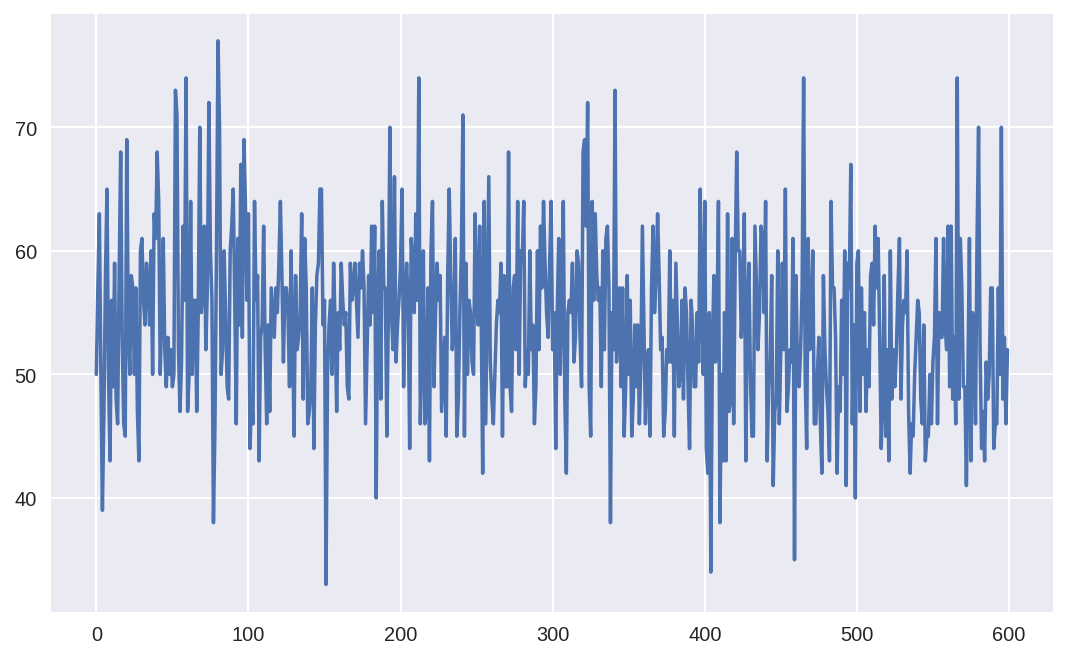

In [40]:
# plot data
X = np.arange(data_.shape[0])
plt.plot(X, data_)


**Exponentailfunktion**

![Exponentail Funktion](http://mathworld.wolfram.com/images/interactive/ExpReal.gif)

**Sigmoid**

![Exponentail Funktion](https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Sigmoid-function-2.svg/2000px-Sigmoid-function-2.svg.png)

**Exponential  Verteilung (PDF)**

![Exponentail Funktion](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Exponential_pdf.svg/325px-Exponential_pdf.svg.png)

**Poisson Verteilung (PDF)**

![Exponentail Funktion](https://upload.wikimedia.org/wikipedia/commons/thumb/1/16/Poisson_pmf.svg/325px-Poisson_pmf.svg.png)

---


**Modell**

```
Zeitpunkt der Inspektion
τ ~ Uniform()

Paramter der Posterior Distribution
α = 1 / mean(data) 
λ1 ~ Exp(α)
λ2 ~ Exp(α)

Ergebnis (Posterior Distribution)
λ(x) = wenn (x < τ) dann λ1 sonst λ2
observation(x) ~ Poisson(λ(x))
```

3 unbekannte Variablen (Dimensionen): λ1, λ2,  τ

In [41]:
# Set the chain's start state.
initial_chain_state = [
  tf.cast(tf.reduce_mean(data), dtype=tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda1"),
  tf.cast(tf.reduce_mean(data), dtype=tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda2"),
  0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
]

unconstraining_bijectors = [
  tfp.bijectors.Exp(),       # Maps a positive real to R.
  tfp.bijectors.Exp(),       # Maps a positive real to R.
  tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
]

def joint_log_prob(count_data, lambda_1, lambda_2, tau):
  alpha = np.array(1. / count_data.mean(), np.float32)
  rv_lambda_1 = tfd.Exponential(rate=alpha)
  rv_lambda_2 = tfd.Exponential(rate=alpha)

  rv_tau = tfd.Uniform()

  lambda_ = tf.gather(
       [lambda_1, lambda_2],
       indices=tf.cast(tau * count_data.size <= np.arange(count_data.size), dtype=tf.int32))
  rv_observation = tfd.Poisson(rate=lambda_)
  
  print(alpha)

  return (
       rv_lambda_1.log_prob(lambda_1)
       + rv_lambda_2.log_prob(lambda_2)
       + rv_tau.log_prob(tau)
       + tf.reduce_sum(rv_observation.log_prob(count_data))
  )

def unnormalized_log_posterior(lambda1, lambda2, tau):
  return joint_log_prob(data_, lambda1, lambda2, tau)


# Initialize the step_size. (It will be automatically adapted.)
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
  step_size = tf.get_variable(
    name='step_size',
    initializer=tf.constant(0.05, dtype=tf.float32),
    trainable=False,
    use_resource=True
  )

# Sample from the chain.
[
  lambda_1_samples,
  lambda_2_samples,
  posterior_tau,
], kernel_results = tfp.mcmc.sample_chain(
  num_results=1000,
  num_burnin_steps=500,
  current_state=initial_chain_state,
  kernel=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=unnormalized_log_posterior,
      num_leapfrog_steps=2,
      step_size=step_size,
      step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(None),
      state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors))

tau_samples = tf.floor(posterior_tau * tf.cast(tf.size(data_), dtype=tf.float32))

# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tf.shape(tau_samples)[0]


# Initialize any created variables.
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

0.018491695
0.018491695


In [42]:
evaluate(init_g)
evaluate(init_l)
[
    lambda_1_samples_,
    lambda_2_samples_,
    tau_samples_,
    kernel_results_,
    N_
] = evaluate([
    lambda_1_samples,
    lambda_2_samples,
    tau_samples,
    kernel_results,
    N
])

    
print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

acceptance rate: 0.681
final step size: 0.012313047423958778


Text(0, 0.5, 'probability')

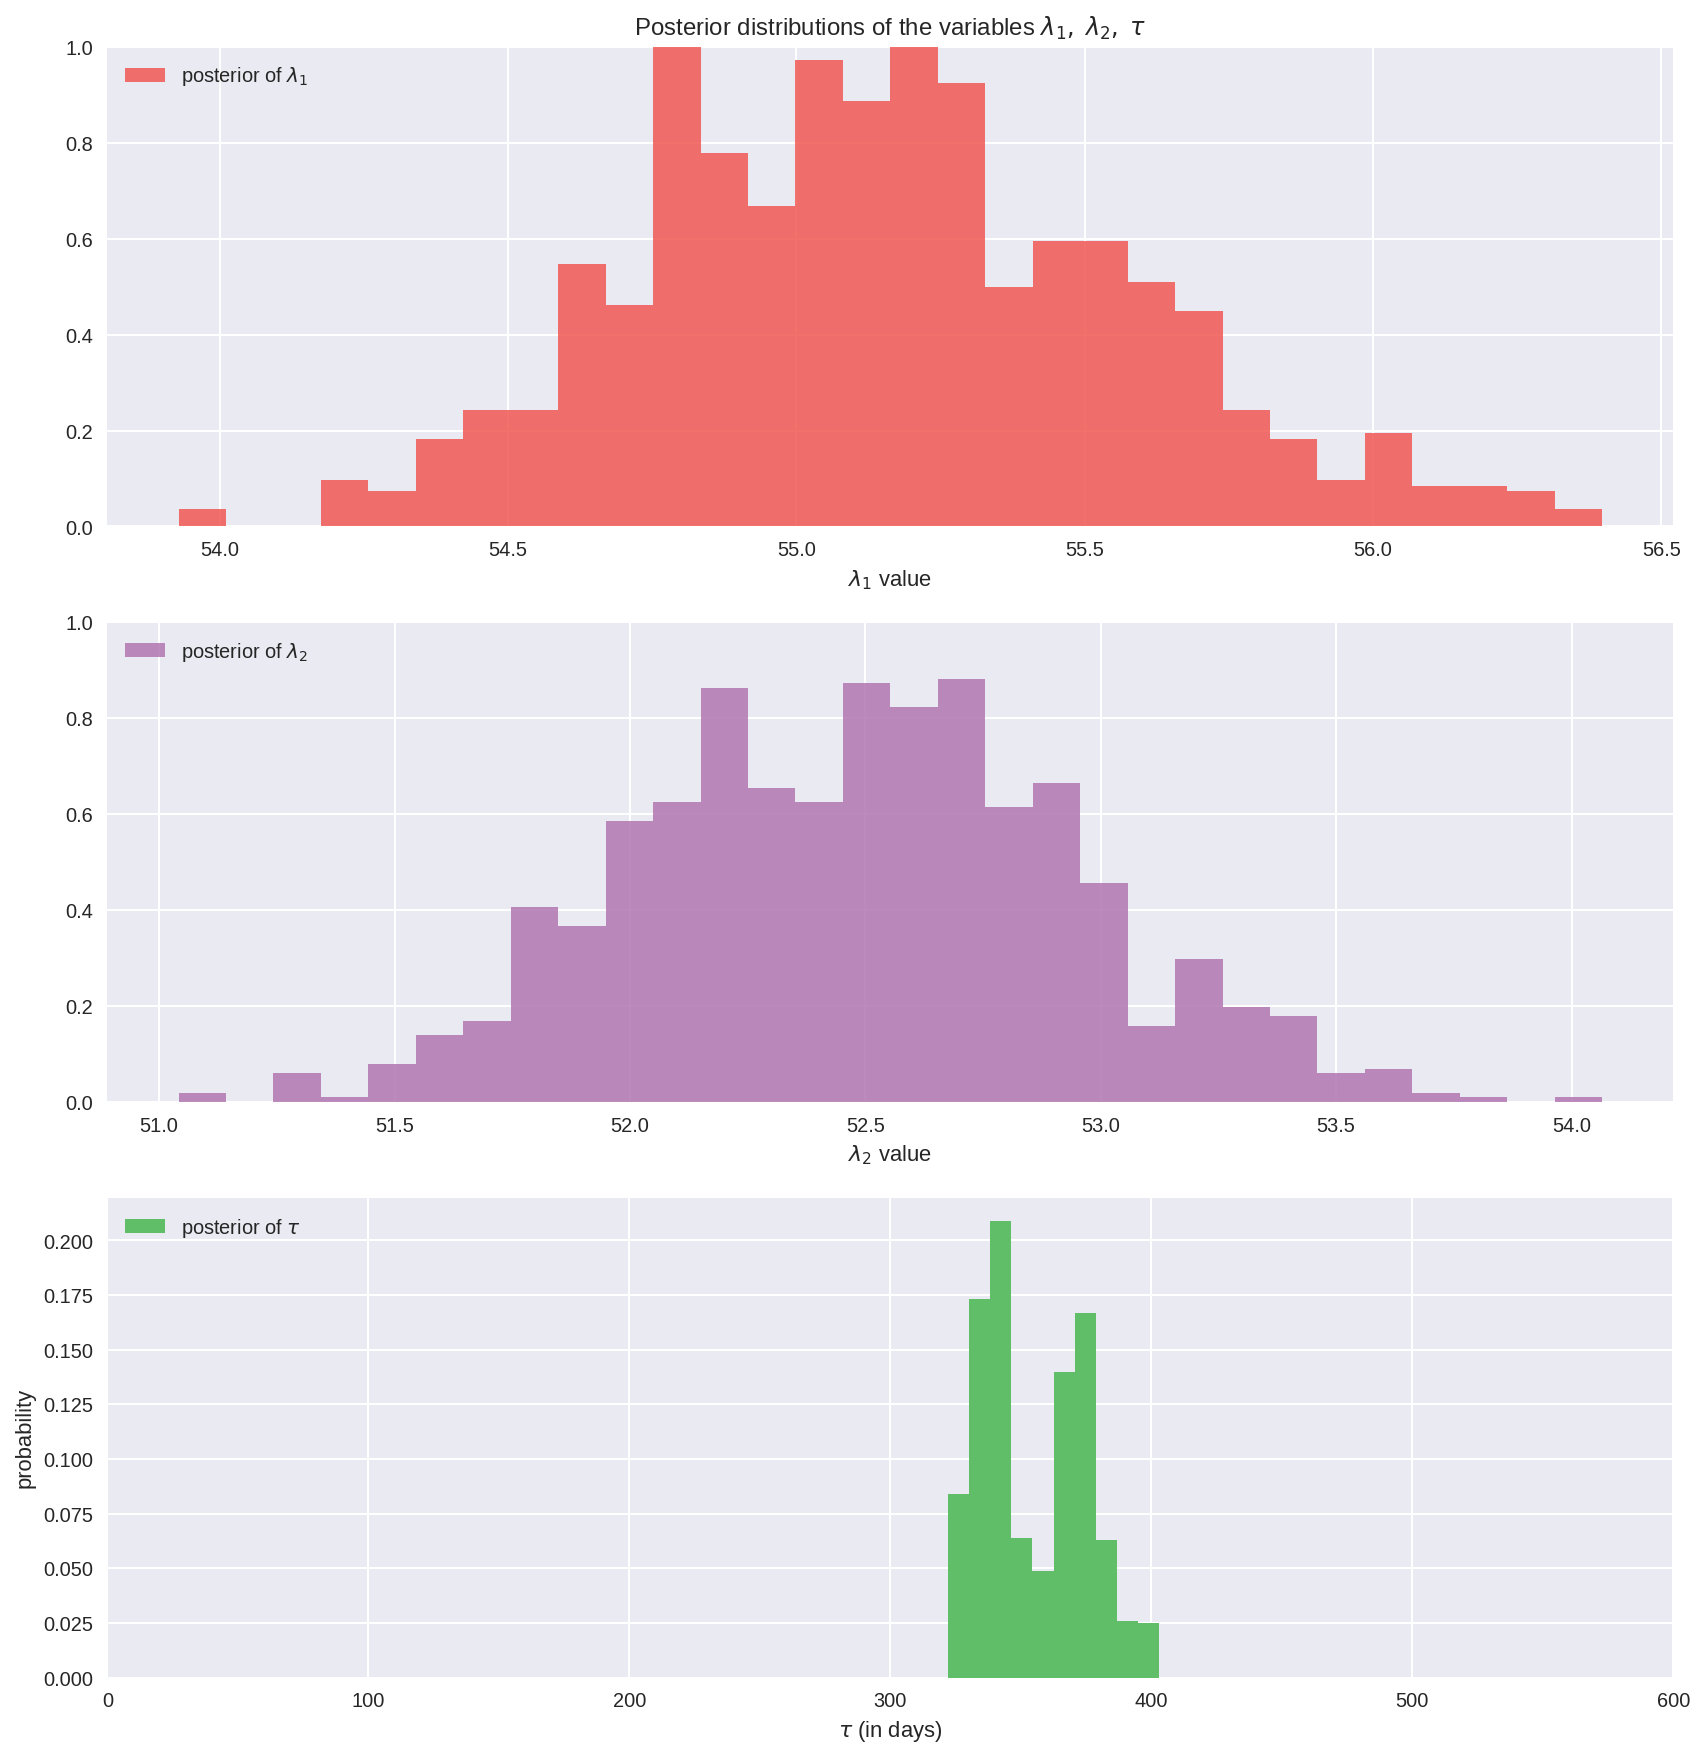

In [43]:
plt.figure(figsize=(12.5, 15))
#histogram of the samples:




ax = plt.subplot(311)
ax.set_autoscaley_on(False)
plt.hist(lambda_1_samples_, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_1$", color=TFColor[0], density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlabel(r"$\lambda_1$ value")




ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples_, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_2$", color=TFColor[6], density=True)
plt.legend(loc="upper left")
plt.xlabel(r"$\lambda_2$ value")


plt.subplot(313)
w = 1.0 / tau_samples_.shape[0] * np.ones_like(tau_samples_)
plt.hist(tau_samples_, bins=10, alpha=1,
         label=r"posterior of $\tau$",
         color=TFColor[2], weights=w, rwidth=2.)

plt.legend(loc="upper left")
plt.xlim([0, data_.shape[0]])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel(r"probability")

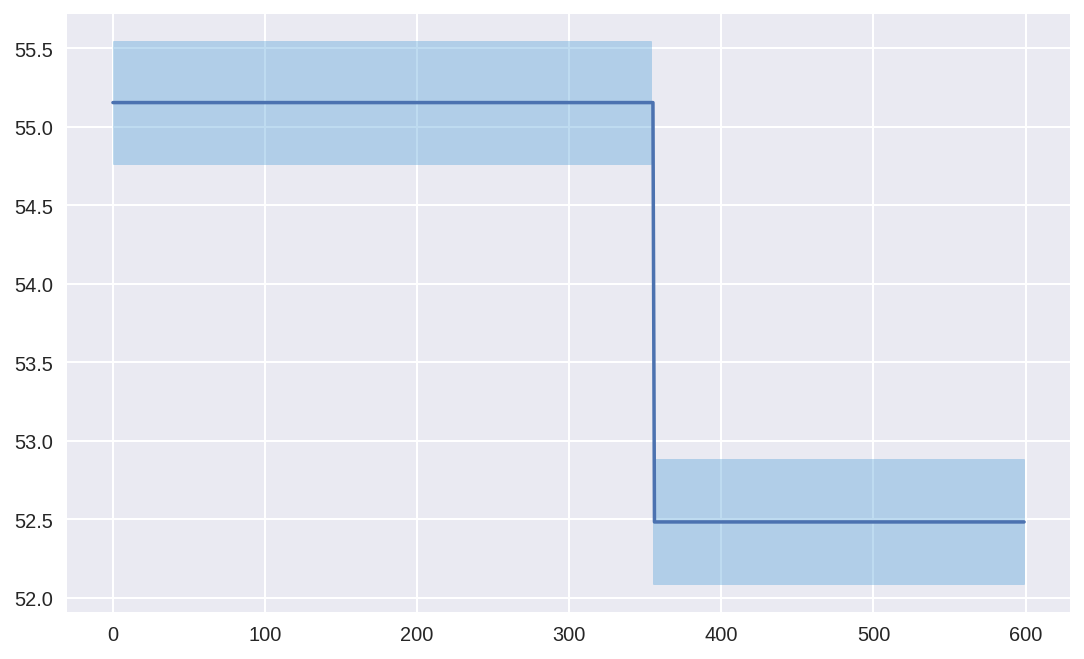

In [44]:
alpha = np.array(1. / data_.mean(), np.float32)
lambda_1 = lambda_1_samples_.mean()
lambda_1_std = lambda_1_samples_[-300:].std()

lambda_2 = lambda_2_samples_.mean()
lambda_2_std = lambda_2_samples_[-300:].std()

tau = tau_samples_.mean()


lambda_ = tf.gather(
     [lambda_1, lambda_2],
     indices=tf.cast(np.arange(data_.size) >= tau, dtype=tf.int32))

dist_samples_ = evaluate(lambda_)


X = np.arange(data_.shape[0])
plt.plot(X, dist_samples_)
plt.fill_between(X[:int(tau)], lambda_1 - lambda_1_std, lambda_1 + lambda_1_std, color=TFColor[3], alpha=0.4)
plt.fill_between(X[int(tau):], lambda_2 - lambda_2_std, lambda_2 + lambda_2_std, color=TFColor[3], alpha=0.4)
plt.show()